In [207]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath("../pipeline"))

from ingest_clean import clean_data


In [208]:
df = pd.read_parquet("../data/processed/cleaned_sales.parquet")

In [209]:
df.shape
df.columns
df.dtypes
df.describe(include='all')  # Summary of all columns
df.isna().sum()             # Missing values check


row_id           0
order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
customer_name    0
segment          0
country          0
city             0
state            0
postal_code      0
region           0
product_id       0
category         0
sub-category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
dtype: int64

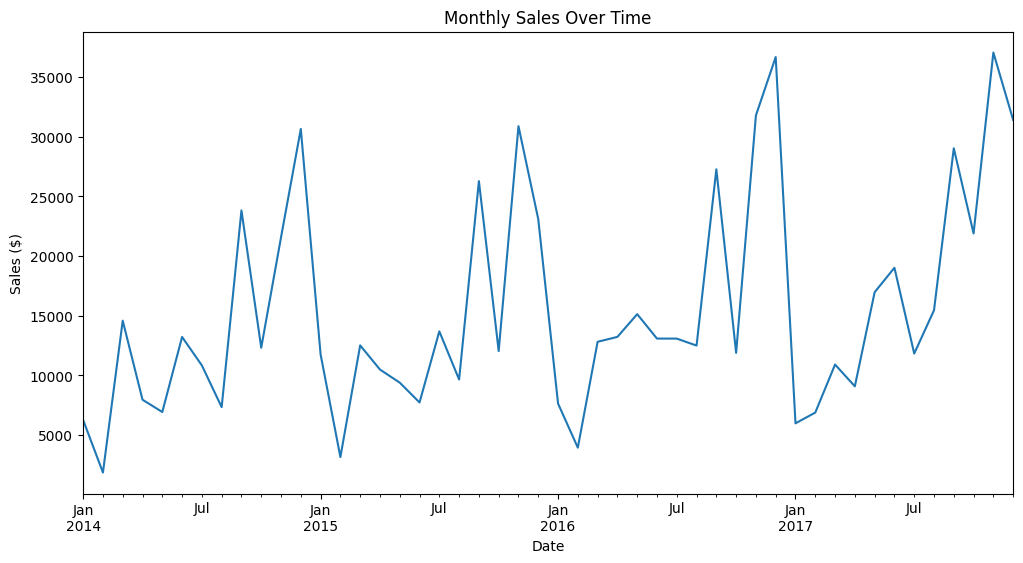

In [210]:
# Monthly Sales Over Time
df['order_date'] = pd.to_datetime(df['order_date'])

# Grouping and plot
monthly_sales = df.set_index('order_date').resample('ME')['sales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.ylabel('Sales ($)')
plt.xlabel('Date')
plt.show()


<Figure size 1400x800 with 0 Axes>

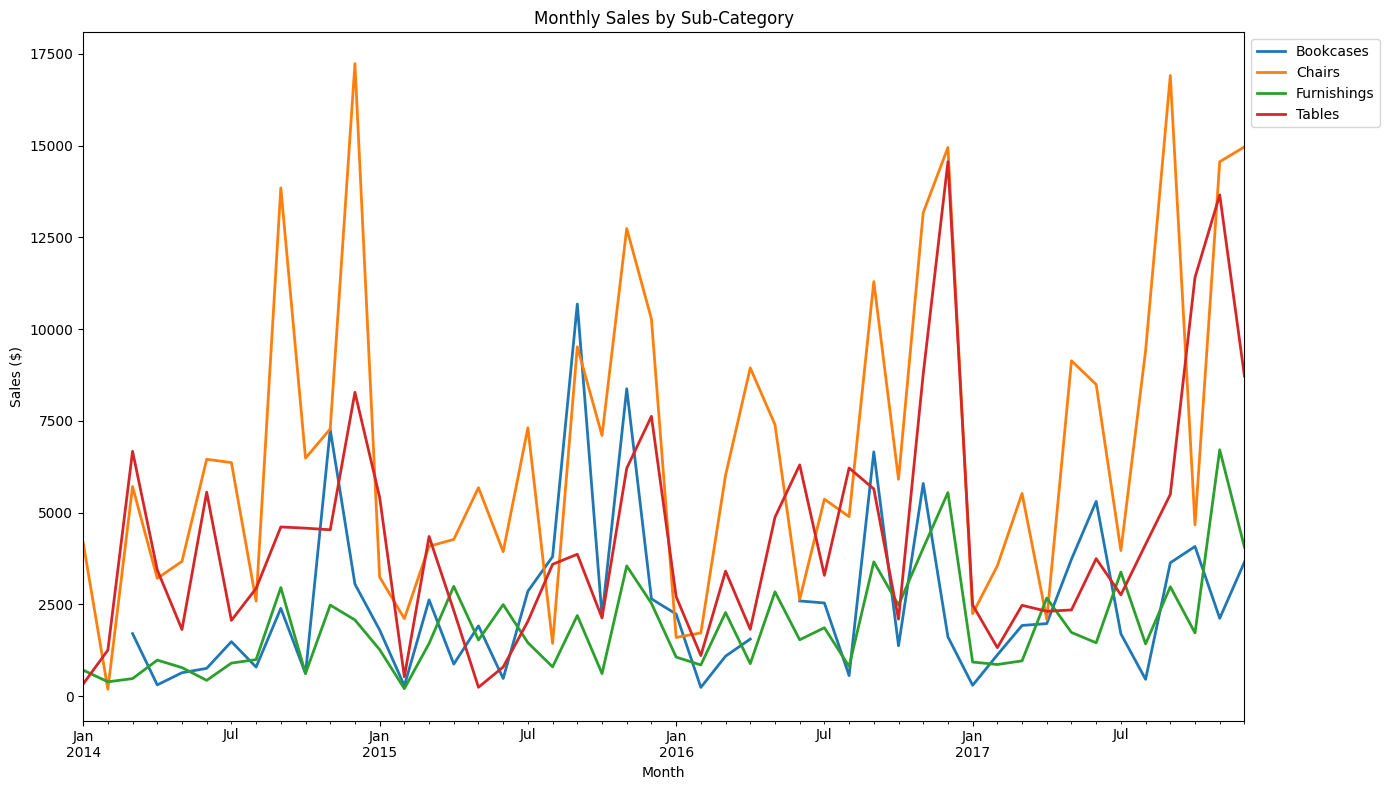

In [211]:
# Ensure date column is datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Group by month + sub-category
monthly_sub = (
    df.groupby([pd.Grouper(key='order_date', freq='ME'), 'sub-category'])['sales']
    .sum()
    .reset_index()
)

# Pivot for multi-line plot
pivot_df = monthly_sub.pivot(index='order_date', columns='sub-category', values='sales')


plt.figure(figsize=(14, 8))
pivot_df.plot(figsize=(14, 8), linewidth=2)
plt.title('Monthly Sales by Sub-Category')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


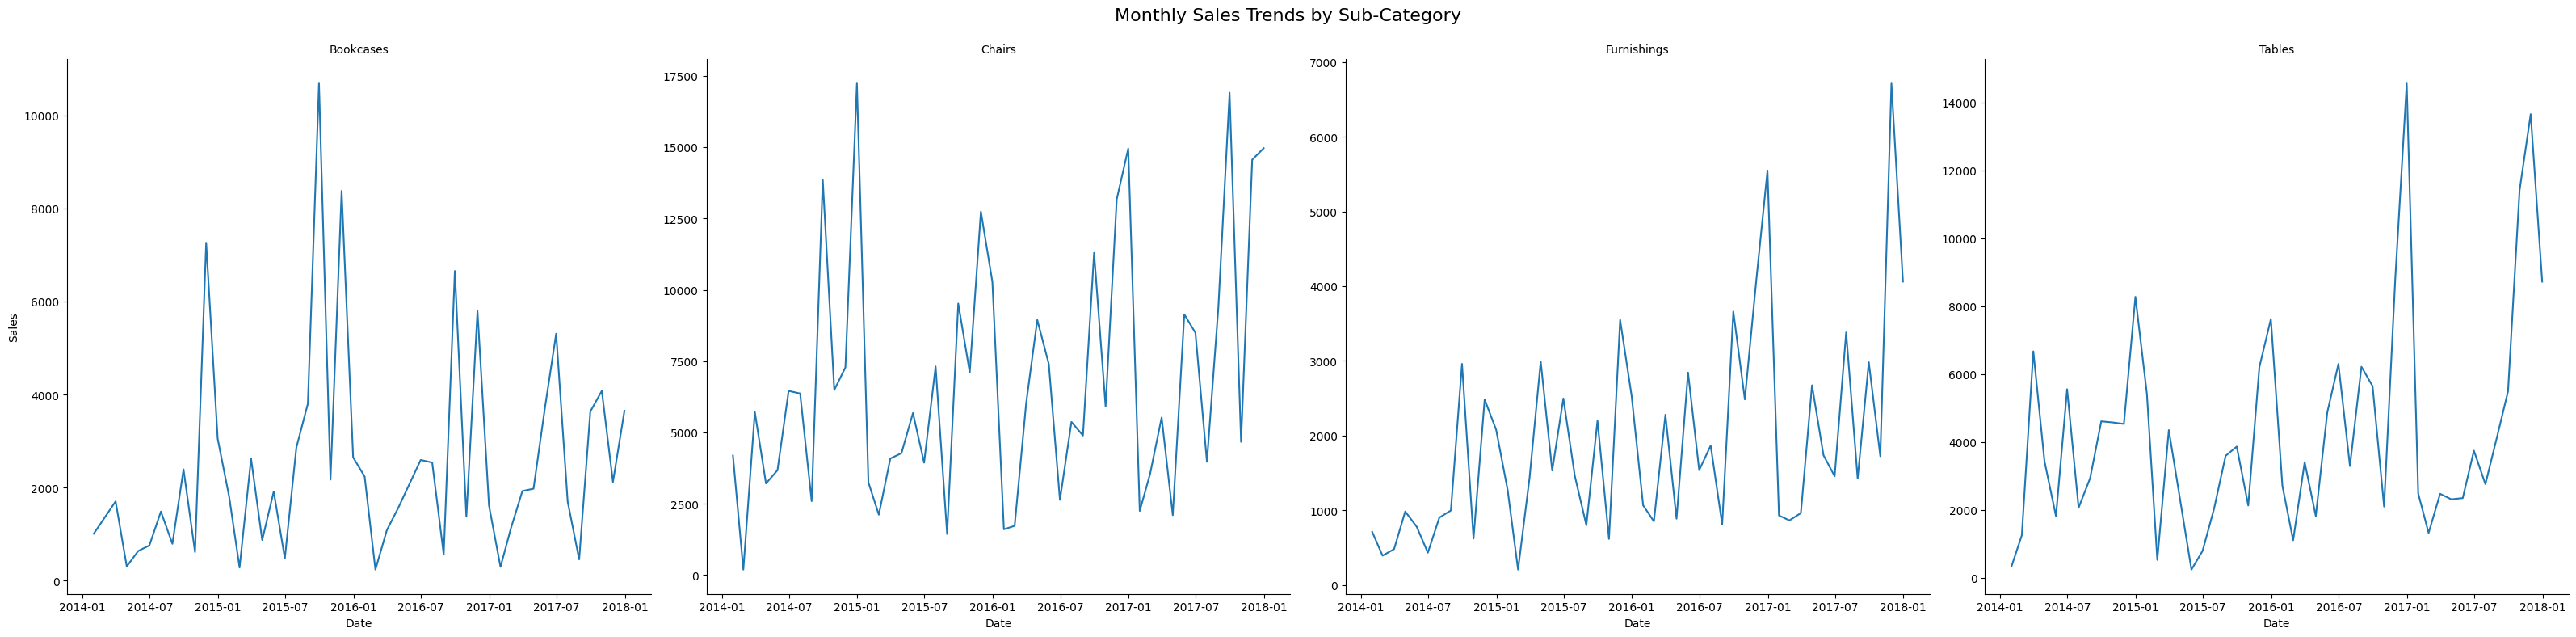

In [212]:
# Reuse same grouped data
monthly_sub = (
    df.groupby([pd.Grouper(key='order_date', freq='ME'), 'sub-category'])['sales']
    .sum()
    .reset_index()
)

# Plot with FacetGrid
g = sns.FacetGrid(monthly_sub, col="sub-category", col_wrap=4, height=8, sharey=False)
g.map_dataframe(sns.lineplot, x="order_date", y="sales")
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Sales")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Sales Trends by Sub-Category', fontsize=16)
plt.show()


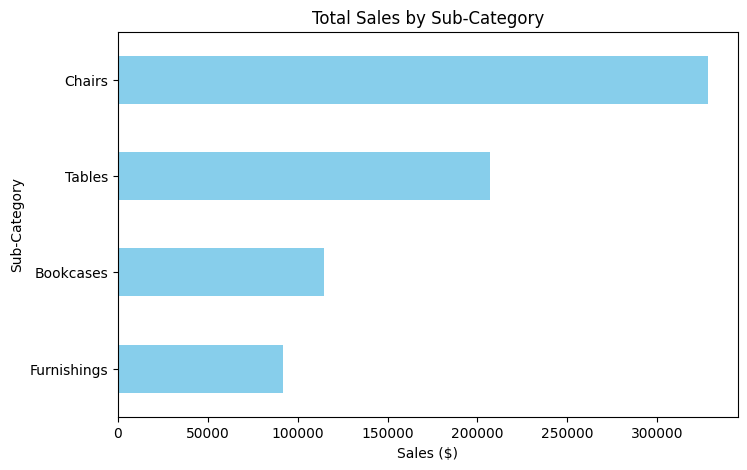

In [213]:
#Total Sales by Sub-Category
subcategory_sales = df.groupby('sub-category')['sales'].sum().sort_values()

plt.figure(figsize=(8, 5))
subcategory_sales.plot(kind='barh', color='skyblue')
plt.title('Total Sales by Sub-Category')
plt.xlabel('Sales ($)')
plt.ylabel('Sub-Category')
plt.show()


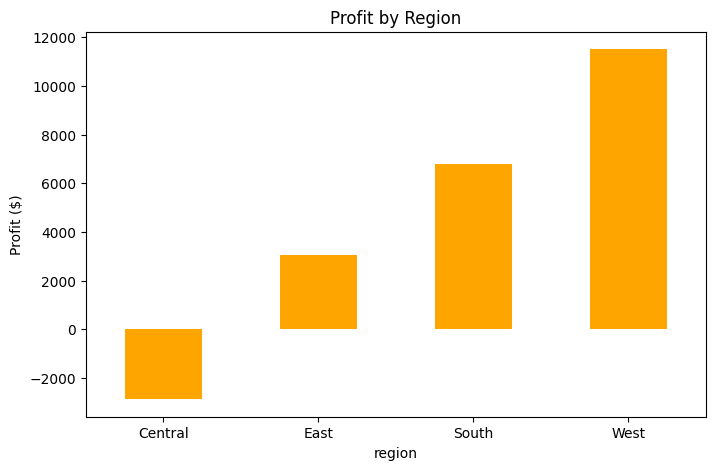

In [214]:
#Profit by Region Graph
region_profit = df.groupby('region')['profit'].sum().sort_values()

plt.figure(figsize=(8, 5))
region_profit.plot(kind='bar', color='orange')
plt.title('Profit by Region')
plt.ylabel('Profit ($)')
plt.xticks(rotation=0)
plt.show()




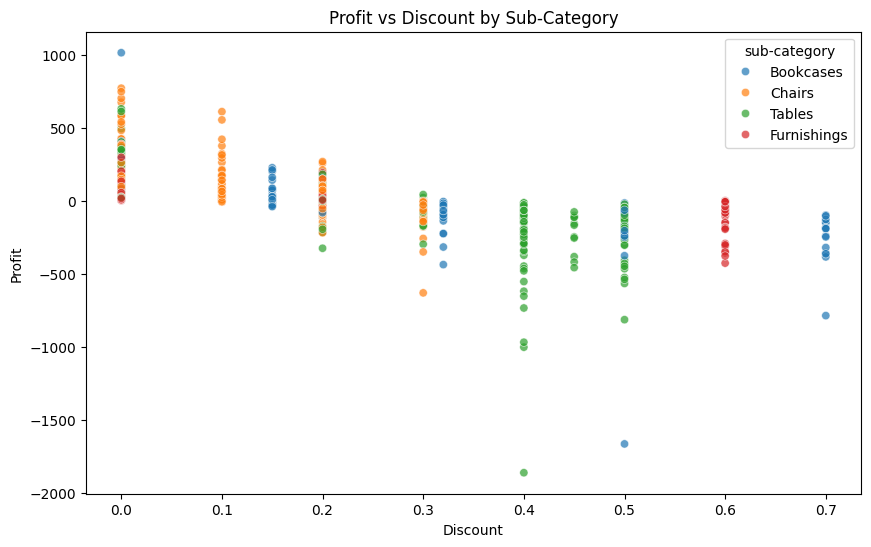

In [215]:
# Sub-Category Profit vs Discont
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='discount', y='profit', hue='sub-category', alpha=0.7)
plt.title('Profit vs Discount by Sub-Category')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()


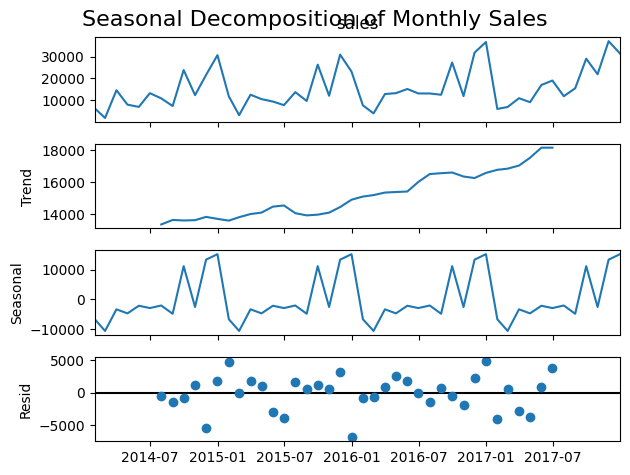

In [216]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample total sales monthly
df['order_date'] = pd.to_datetime(df['order_date'])
monthly_sales = df.set_index('order_date').resample('ME')['sales'].sum()

# Run decomposition (additive is usually best for sales data)
# Trend - Overall Direction
# Seasonality - Recurring Patterns
# Residual (Noise) - What's left over after removing trend and seasonality
result = seasonal_decompose(monthly_sales, model='additive')

# Plot all components
result.plot()
plt.suptitle('Seasonal Decomposition of Monthly Sales', fontsize=16)
plt.show()


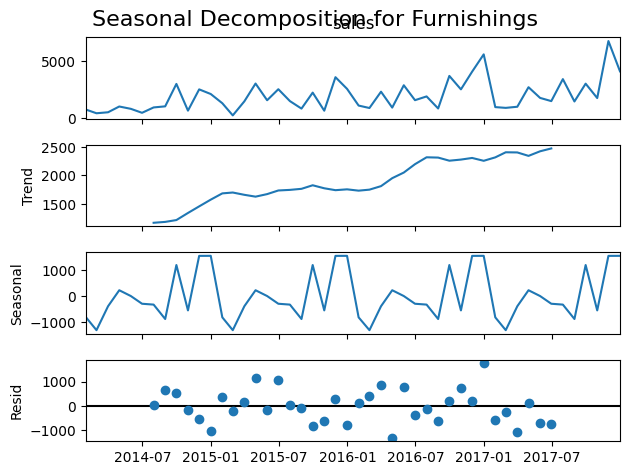

In [217]:
sub_name = 'Furnishings'  # Change this to try other sub-categories (Bookcases, Chairs, Tables, or Furnishings)

sub_df = df[df['sub-category'] == sub_name]
monthly_sub_sales = sub_df.set_index('order_date').resample('ME')['sales'].sum()

result = seasonal_decompose(monthly_sub_sales, model='additive')
result.plot()
plt.suptitle(f'Seasonal Decomposition for {sub_name}', fontsize=16)
plt.show()

# Bookcases shows an interesting plateau (~2015/01 - 2016/07) then drop Trend 
# All items show expected seasonal volatility

In [218]:
# Create new columns from order_date
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['quarter'] = df['order_date'].dt.quarter
df['day'] = df['order_date'].dt.day
df['weekday'] = df['order_date'].dt.day_name()
df['week'] = df['order_date'].dt.isocalendar().week
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])



In [219]:

df['sales_per_item'] = df['sales'] / df['quantity']

df['profit_margin'] = df['profit'] / df['sales']
df['discount_pct'] = df['discount'] * 100

df = df.sort_values('order_date')
df['rolling_sales_3mo'] = df['sales'].rolling(window=3).mean()
df['rolling_sales_6mo'] = df['sales'].rolling(window=6).mean()

df['rolling_subcat_sales'] = (
    df.groupby('sub-category')['sales']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

#df = pd.get_dummies(df, columns=['region', 'category', 'segment'], drop_first=True)


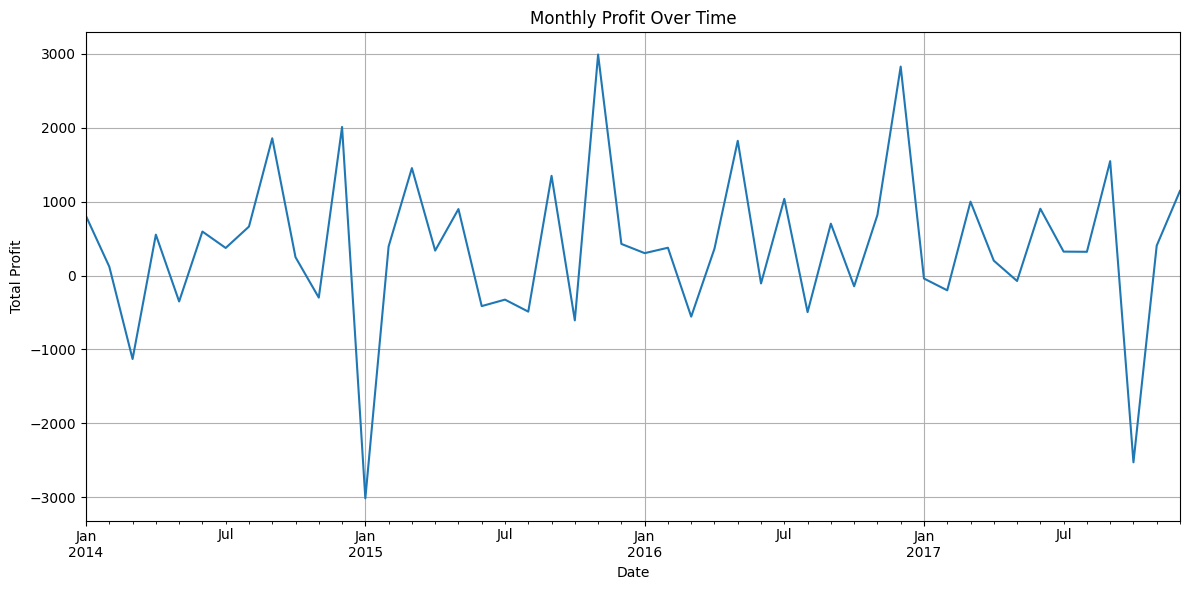

In [220]:
monthly_profit = df.set_index('order_date').resample('ME')['profit'].sum()

plt.figure(figsize=(12, 6))
monthly_profit.plot()
plt.title('Monthly Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interesting findings Jan-2015 massive -3000 profit but a lot of the months have negative profits for furniture


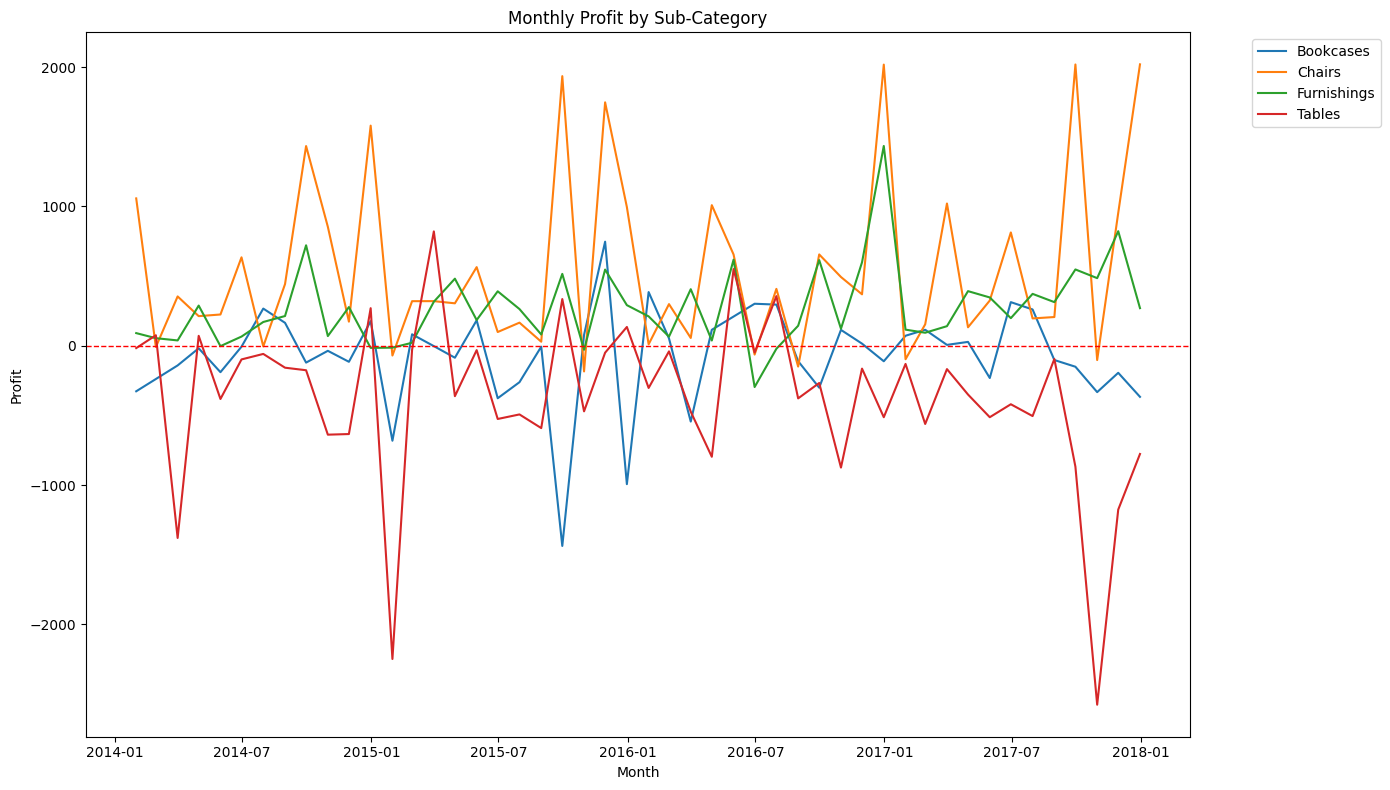

In [221]:
# Grouping by month and sub-category
monthly_profit = (
    df.groupby([pd.Grouper(key='order_date', freq='ME'), 'sub-category'])['profit']
    .sum()
    .reset_index()
)

# Plotting
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_profit, x='order_date', y='profit', hue='sub-category')
plt.title('Monthly Profit by Sub-Category')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Following from the previous findings, Tables and Bookcases seems to be the heaviest hitters for negative profit


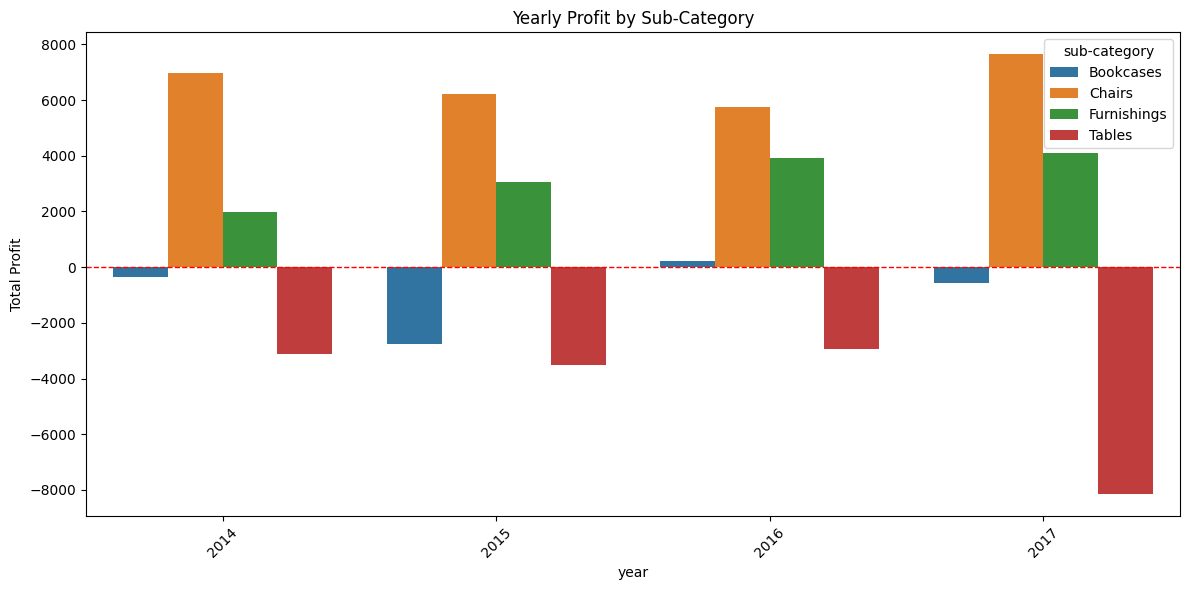

In [222]:
# Grouping by year and sub-category
df['year'] = df['order_date'].dt.year

yearly_profit = (
    df.groupby(['year', 'sub-category'])['profit']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_profit, x='year', y='profit', hue='sub-category')
plt.title('Yearly Profit by Sub-Category')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Exactly what is expected from the previous graph, Tables being THE heaviest on total profit. Curious if it is region specific


In [223]:
unprofitable = df[df['profit'] < 0]
display(unprofitable[['order_id', 'product_name', 'sub-category', 'sales', 'profit', 'discount']].head())

# Looking at which orders were the most unprofitable

,order_id,product_name,sub-category,sales,profit,discount
1626,CA-2014-105417,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",Furnishings,76.728,-53.7096,0.6
1355,CA-2014-149524,Sauder Cornerstone Collection Library,Bookcases,61.960,-53.2856,0.5
1131,CA-2014-146591,O'Sullivan 4-Shelf Bookcase in Odessa Pine,Bookcases,181.470,-320.5970,0.7
786,US-2014-117163,Balt Split Level Computer Training Table,Tables,333.000,-16.6500,0.2
97,US-2014-110674,"Global Geo Office Task Chair, Gray",Chairs,129.568,-24.2940,0.2


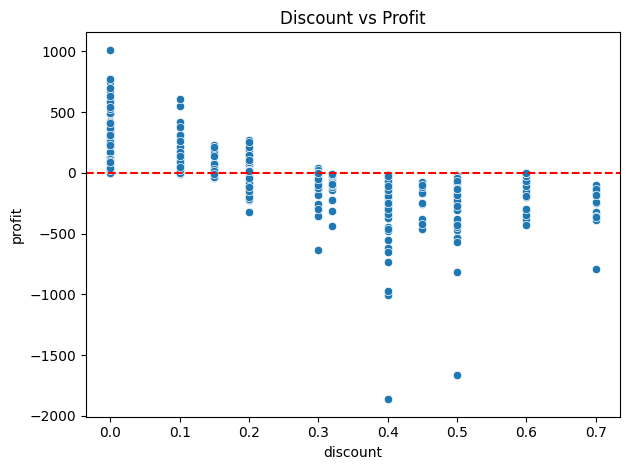

In [224]:
sns.scatterplot(data=df, x='discount', y='profit')
plt.title('Discount vs Profit')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# Recreating a graph previously but with new context and findings are as expected. Higher the discount, the less profit there is to be had

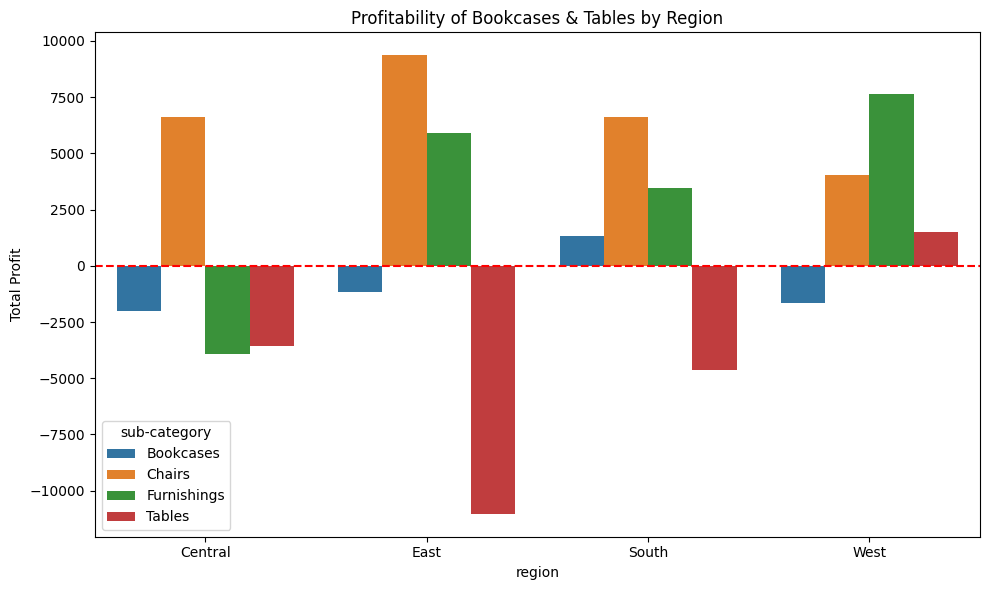

In [225]:
Subfocus_items = df[df['sub-category'].isin(['Bookcases', 'Tables','Chairs','Furnishings'])]

region_Subprofit = (
    Subfocus_items.groupby(['region', 'sub-category'])['profit']
    .sum()
    .reset_index()
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=region_Subprofit, x='region', y='profit', hue='sub-category')
plt.title('Profitability of Bookcases & Tables by Region')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()

# Finding shows that ALL regions have a negative profit for both Bookcases and Tables with exception to South- Bookcases and West- Tables
# Heaviest hitter is East- Tables with a profit of >-10000

#Chairs and furnishings are profitable across all regions with exception to Central - Furnishings (~-4000)
#Central appears to be the most costly region with Chairs being the only profit there and being 2nd highest of the regions for chairs

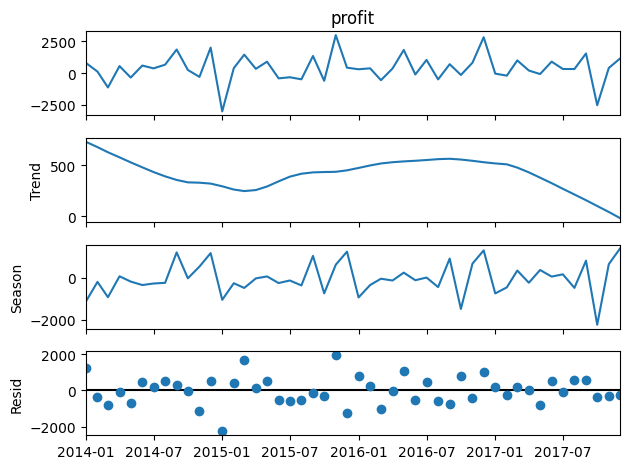

In [229]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()

# Aggregate monthly
monthly_data = df.groupby('month')[['sales', 'profit']].sum().reset_index()

from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Create a time series for profit
monthly_profit_ts = monthly_data.set_index('month')['profit']

stl = STL(monthly_profit_ts, seasonal=13)
res = stl.fit()

res.plot()
plt.show()

# With the trend we can see that profit has been declining 

18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing


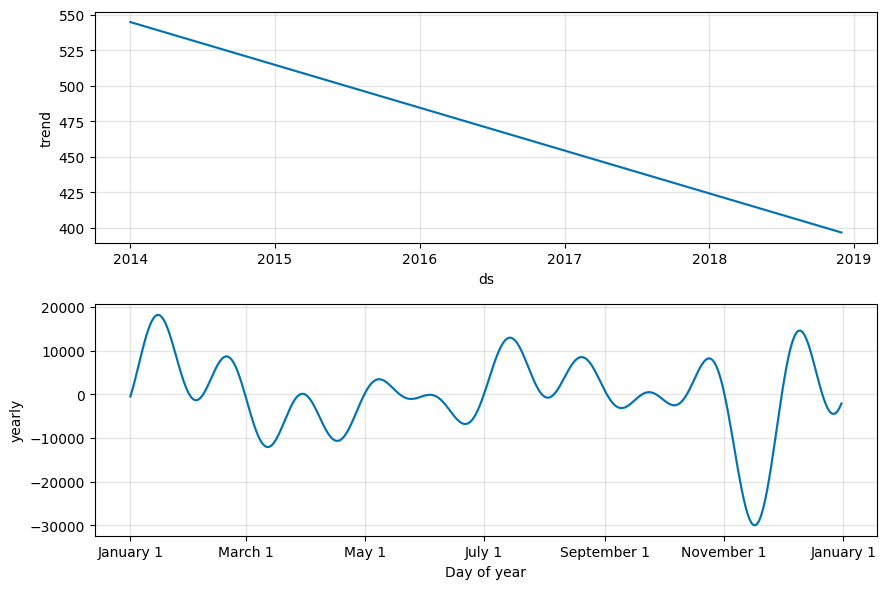

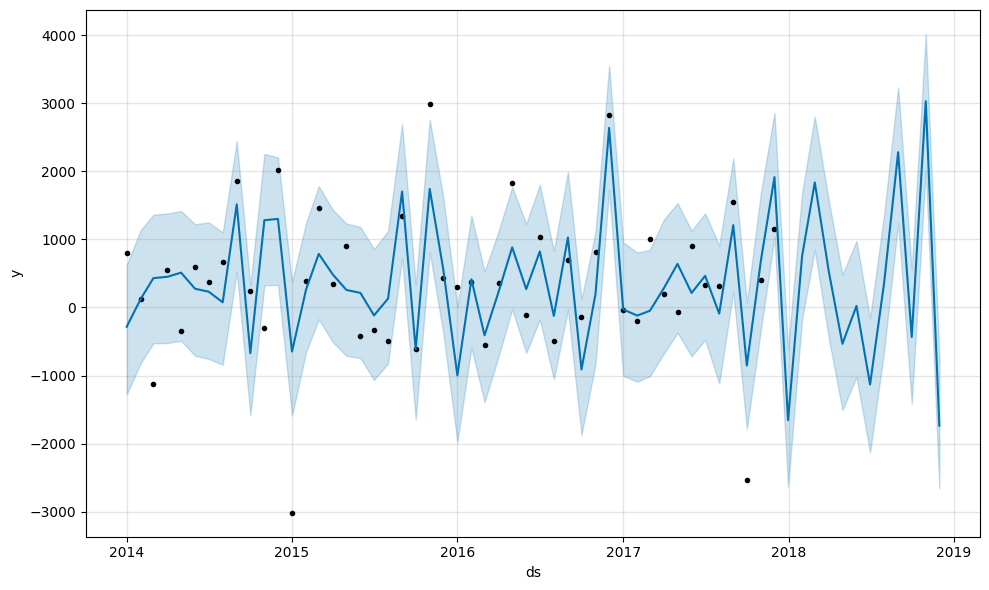

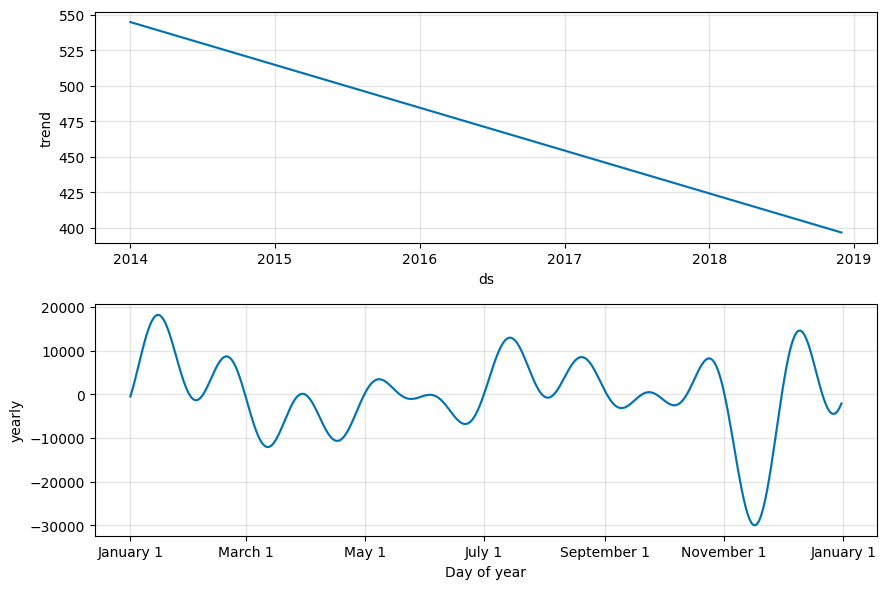

In [ ]:
from prophet import Prophet

# Rename columns for Prophet
profit_data = monthly_data[['month', 'profit']].rename(columns={'month': 'ds', 'profit': 'y'})
m = Prophet()
m.fit(profit_data)

future = m.make_future_dataframe(periods=12, freq='ME')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
m.plot_components(forecast)

# HUGE negative spike in November (-30000) the rest of the months are hills with positive around Jan/Feb close to 18000. The trend shows negative

18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing


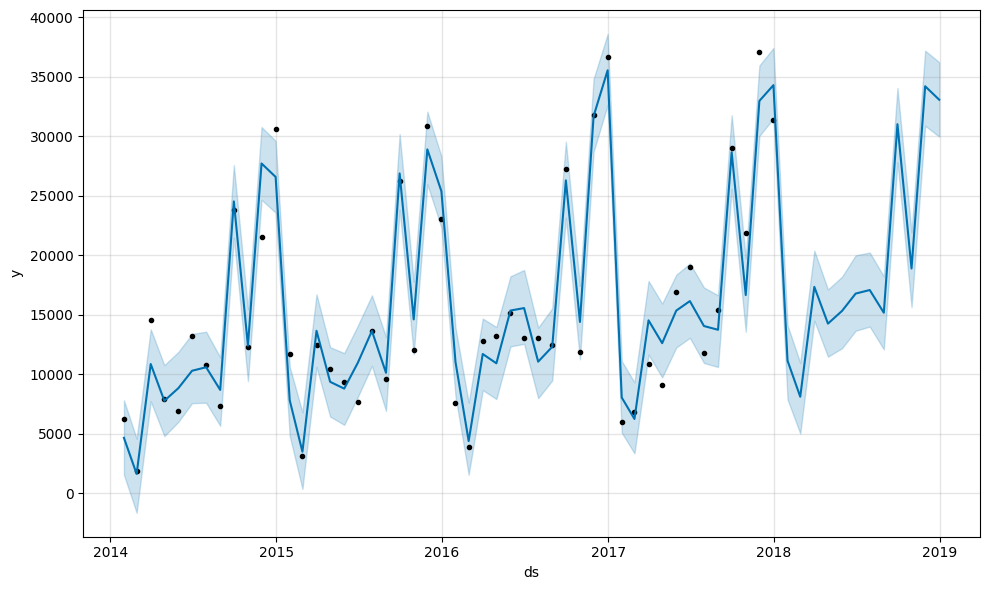

In [227]:

# Forecasting model - Monthly total sales
from prophet import Prophet

monthly = df.set_index('order_date').resample('ME')['sales'].sum().reset_index()
monthly.columns = ['ds', 'y']

model = Prophet()
model.fit(monthly)

future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

fig = model.plot(forecast)


18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing


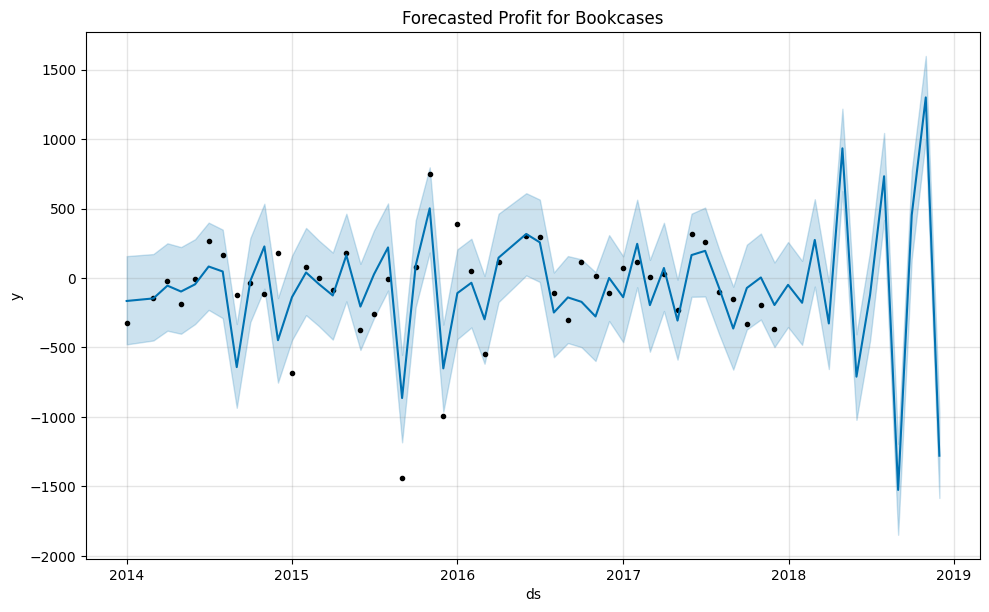

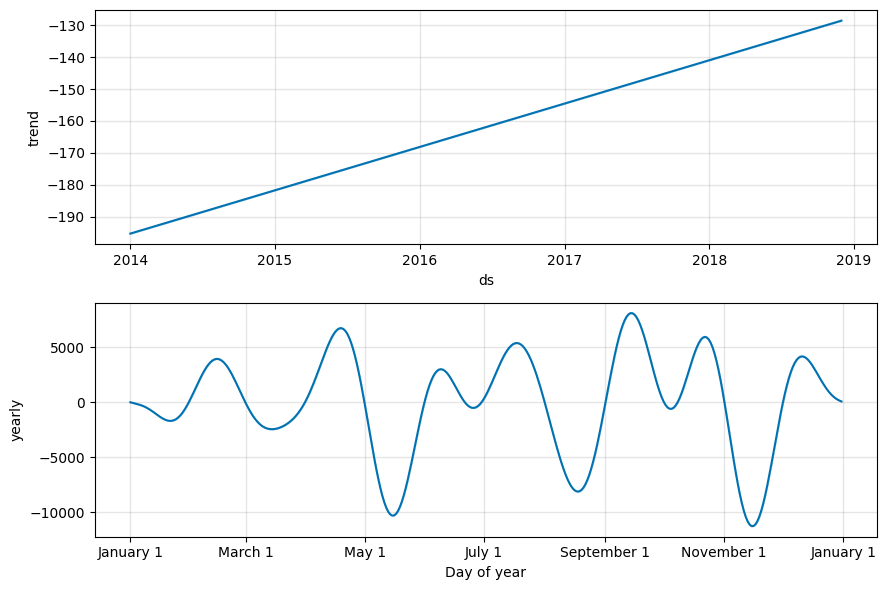

18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing


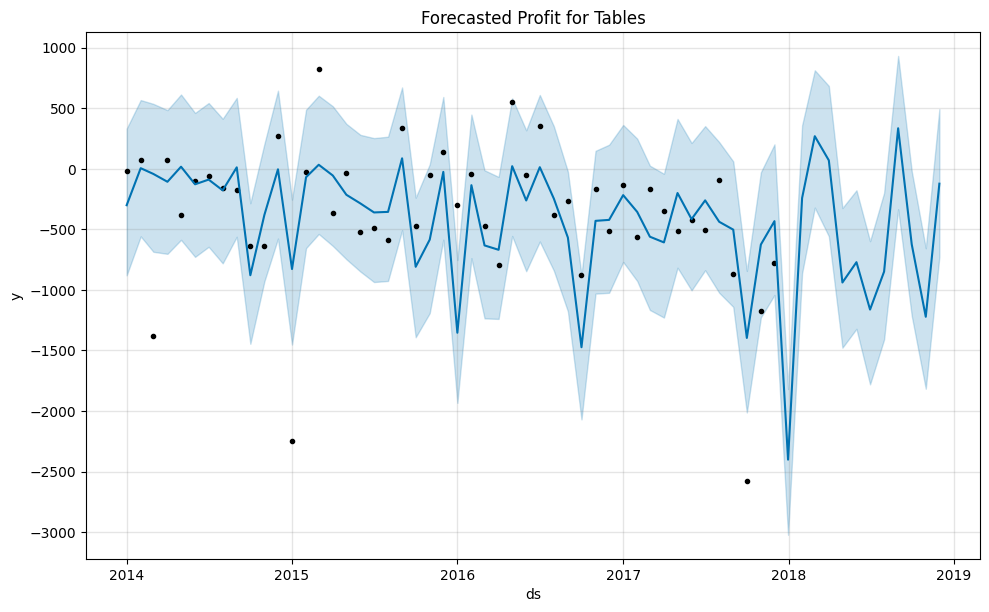

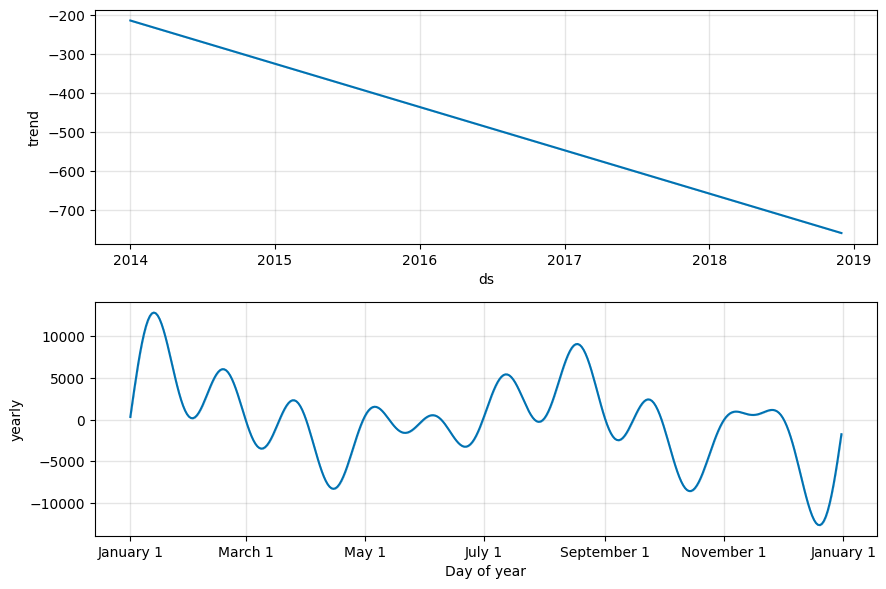

18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] done processing


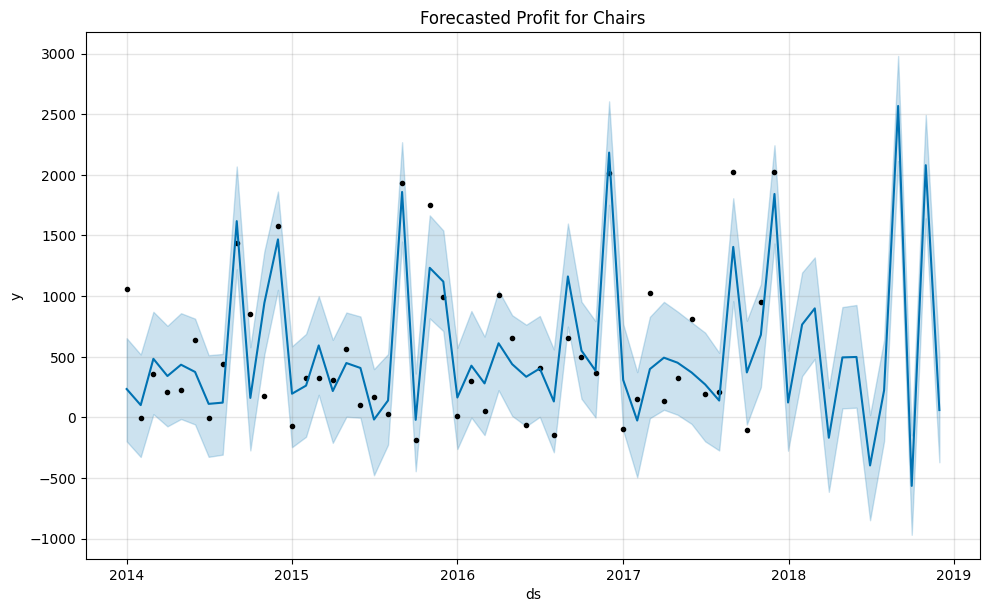

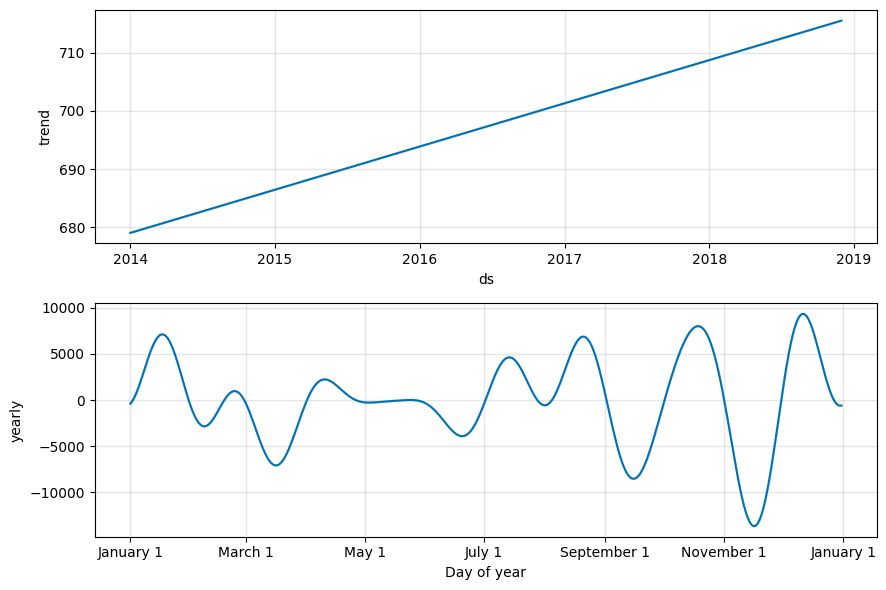

18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing


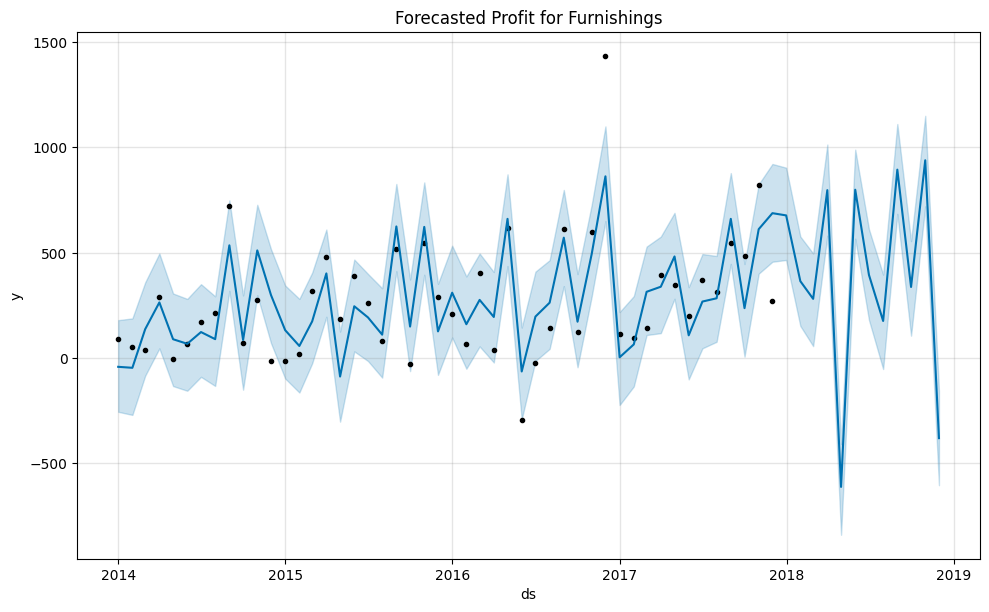

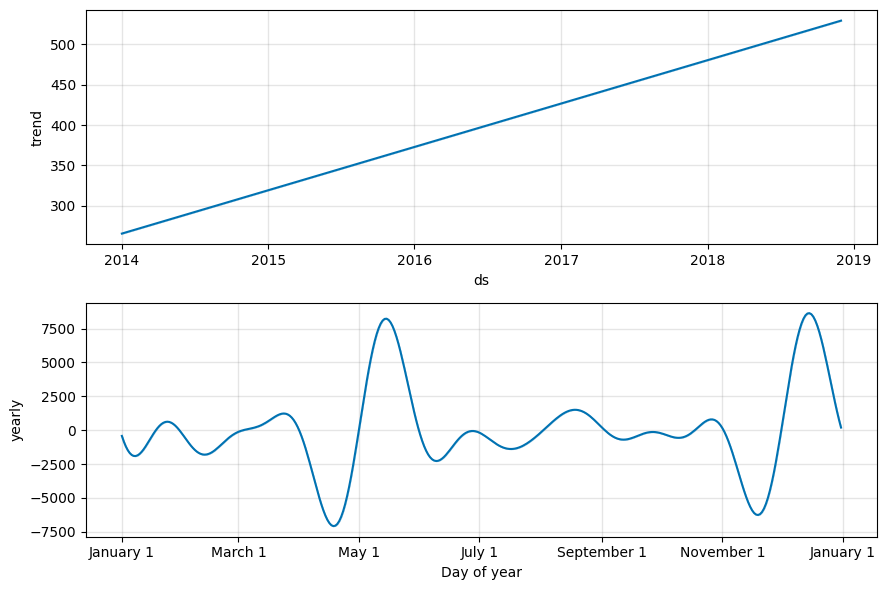

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

subcats = ['Bookcases', 'Tables', 'Chairs', 'Furnishings']  # Sub-Cats being Tables, Chairs, Bookcases, and Furnishings

for subcat in subcats:
    sub_df = df[df['sub-category'] == subcat].copy()
    sub_df['month'] = sub_df['order_date'].dt.to_period('M').dt.to_timestamp()

    monthly_sub = sub_df.groupby('month')['profit'].sum().reset_index()
    monthly_sub = monthly_sub.rename(columns={'month': 'ds', 'profit': 'y'})

    model = Prophet()
    model.fit(monthly_sub)

    future = model.make_future_dataframe(periods=12, freq='ME')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title(f'Forecasted Profit for {subcat}')
    plt.show()

    # Optional: show components
    model.plot_components(forecast)
    plt.show()

# Interesting finding shows that Bookcases does begin to show an upwards trend of profit while Tables continues its downard motif
# Chairs and Furnishings is showing expected upwards trend

# Bookcases and most other sub cats show a sharp decline in profitability during Nov. Possibly due to heavy discounting or seasonal returns while Tables remains relatively stable (pun intended) - hovering around break-even


18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing


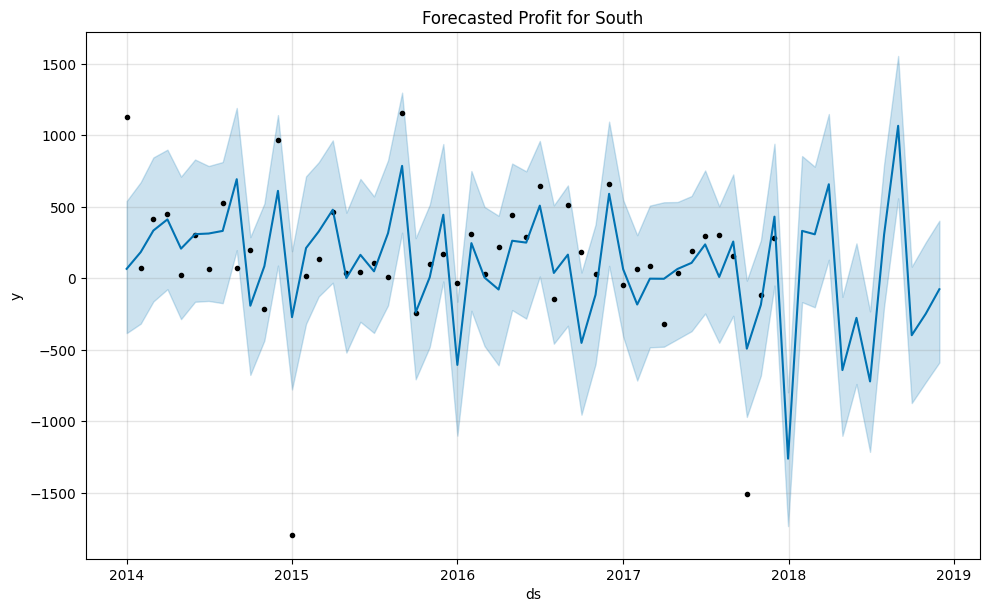

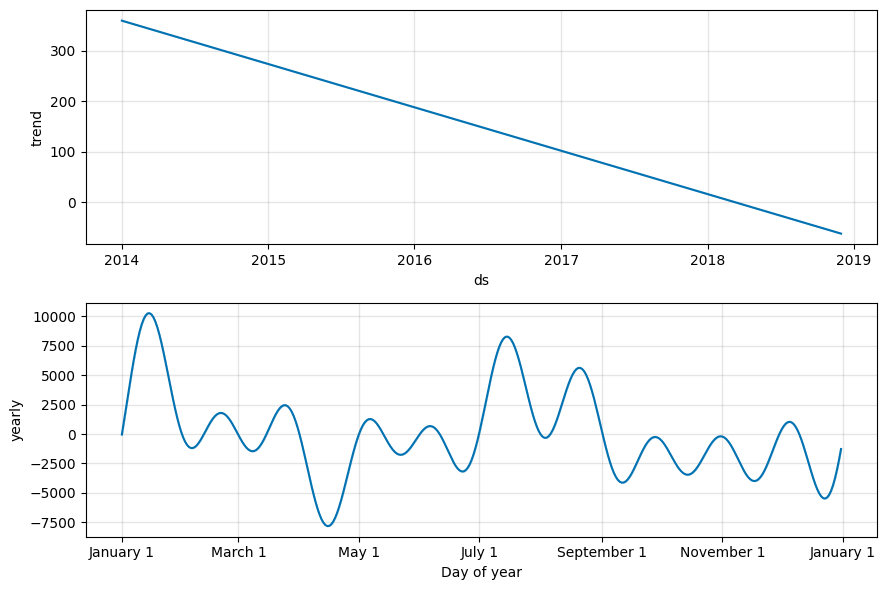

18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing


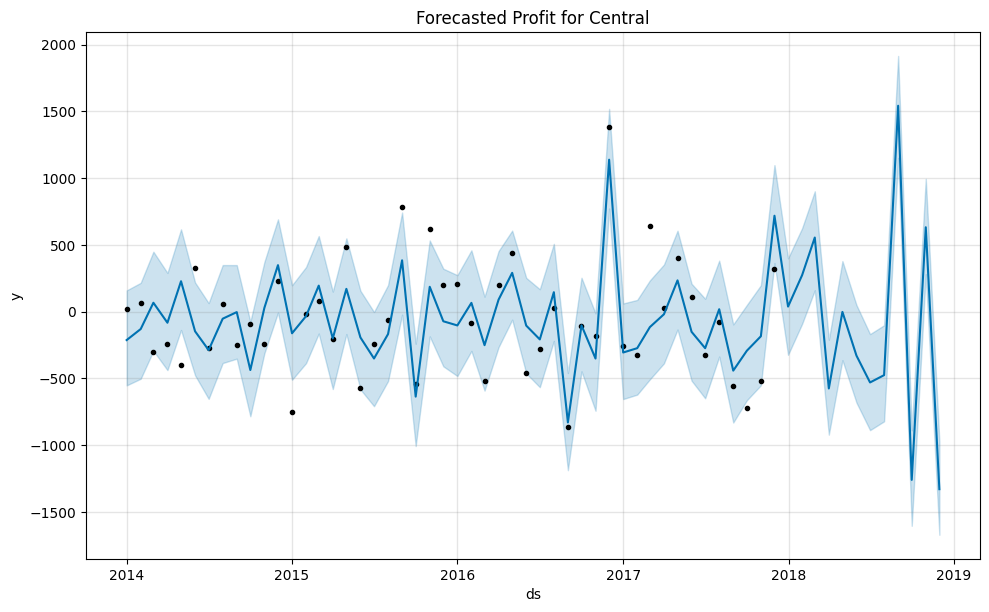

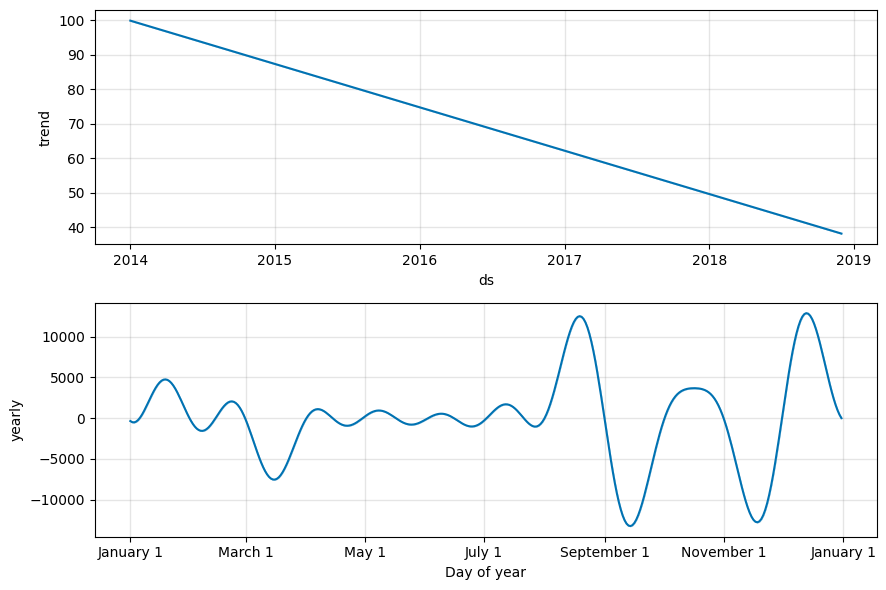

18:24:37 - cmdstanpy - INFO - Chain [1] start processing
18:24:37 - cmdstanpy - INFO - Chain [1] done processing


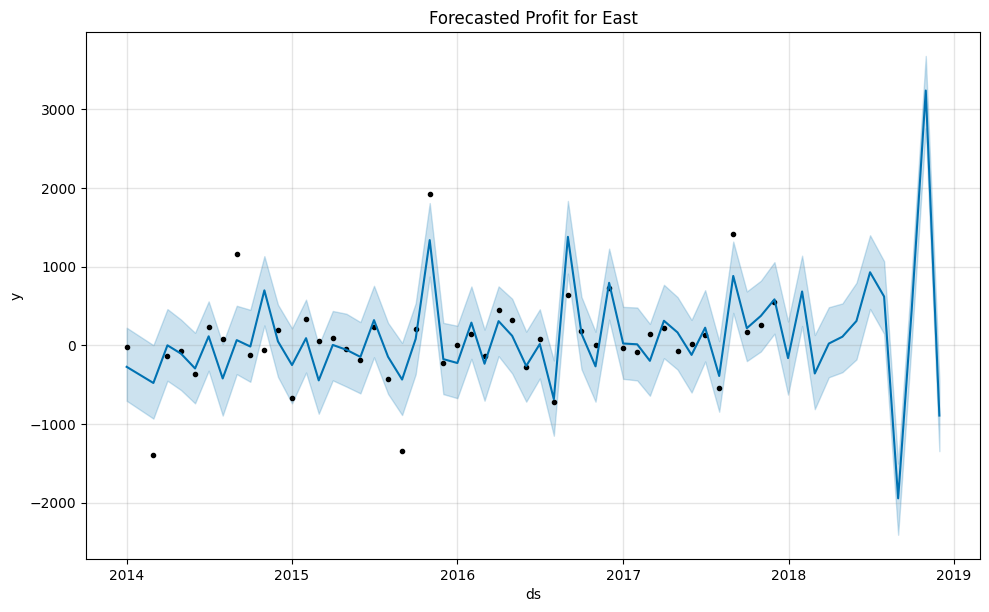

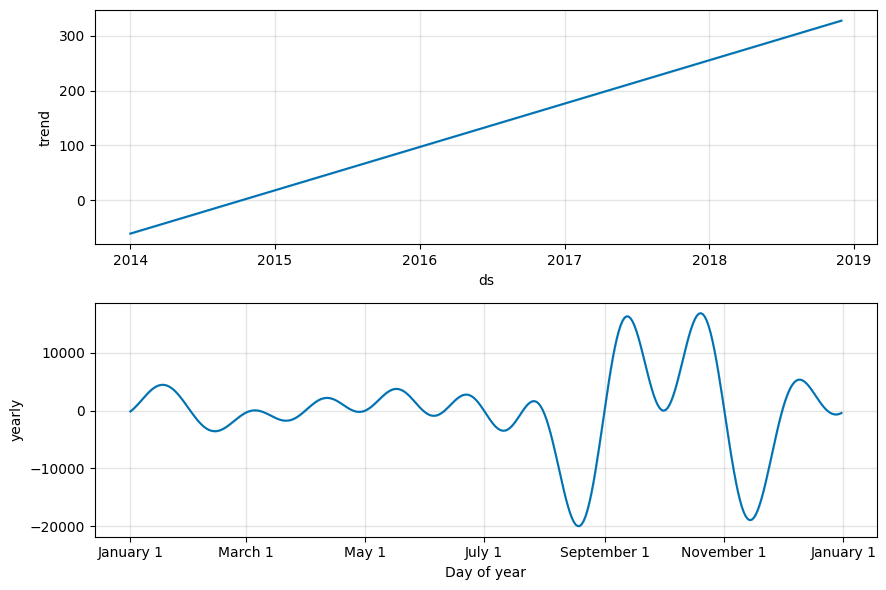

18:24:37 - cmdstanpy - INFO - Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing


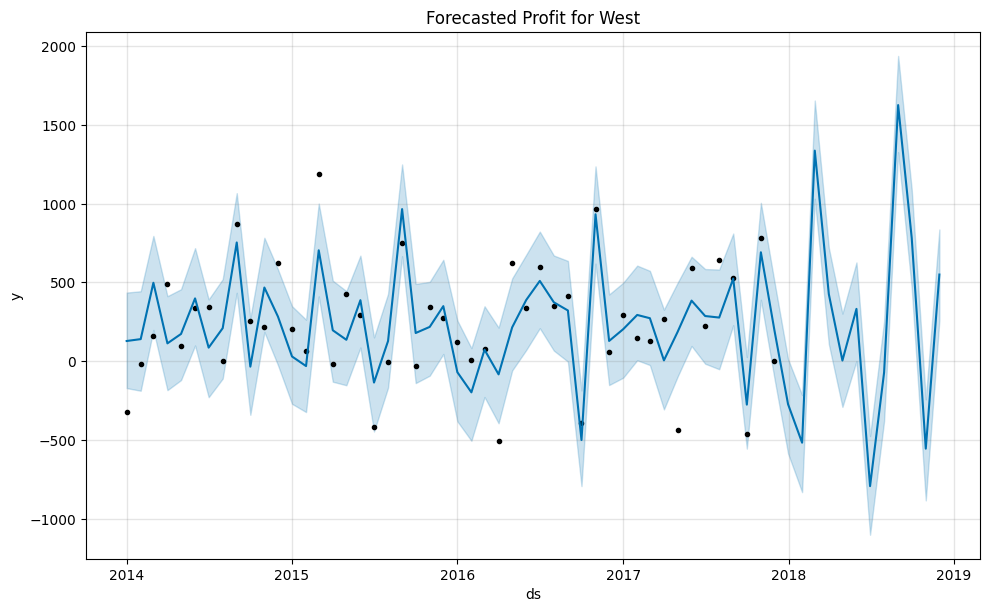

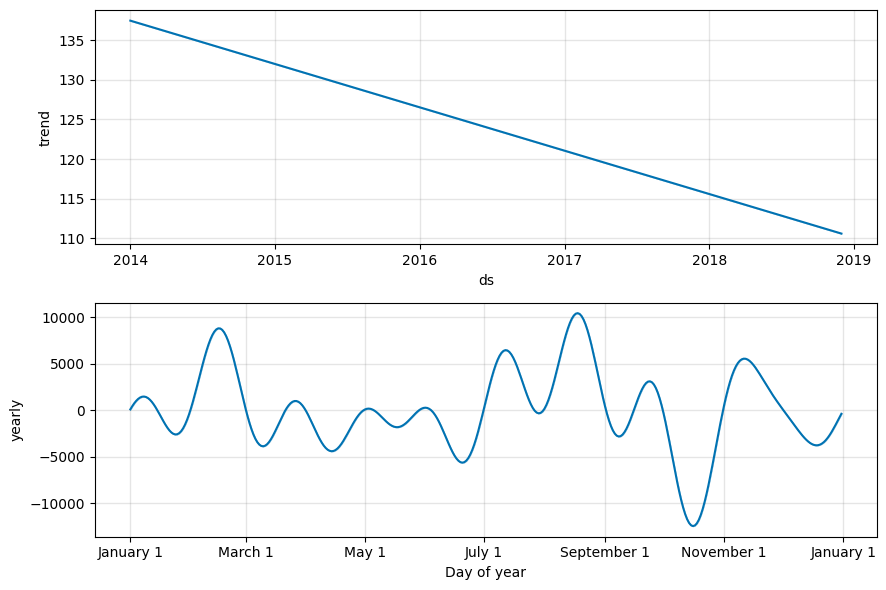

In [ ]:
regions = df['region'].unique()

for region in regions:
    region_df = df[df['region'] == region].copy()
    region_df['month'] = region_df['order_date'].dt.to_period('M').dt.to_timestamp()

    monthly_region = region_df.groupby('month')['profit'].sum().reset_index()
    monthly_region = monthly_region.rename(columns={'month': 'ds', 'profit': 'y'})

    model = Prophet()
    model.fit(monthly_region)

    future = model.make_future_dataframe(periods=12, freq='ME')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title(f'Forecasted Profit for {region}')
    plt.show()

    # Optional component breakdown
    model.plot_components(forecast)
    plt.show()
# East Region is the ONLY region with a postive profitability trend


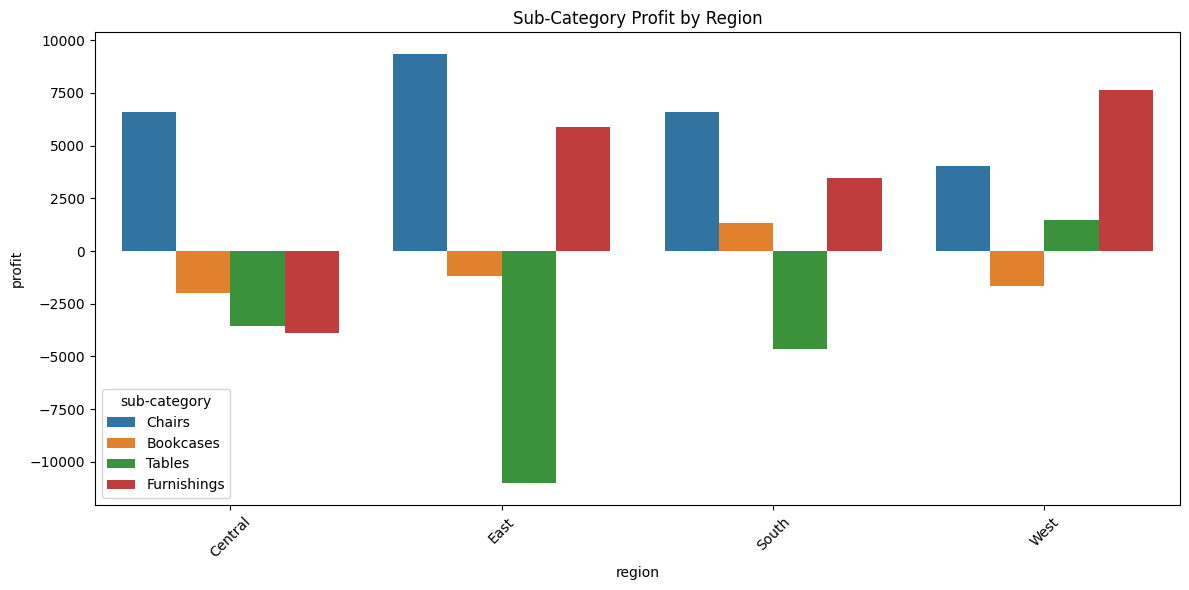

In [ ]:
region_subcat_profit = (
    df.groupby(['region', 'sub-category'])['profit']
    .sum()
    .reset_index()
    .sort_values(['region', 'profit'], ascending=[True, False])
)

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=region_subcat_profit, x='region', y='profit', hue='sub-category')
plt.title('Sub-Category Profit by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Above is already pulled chart from earlier but after the forecasting of above we can now see that mmost of these regions should pull out of selling Tables or rework their marketing / selling strategy with them as these items are what is showing a very real impact into the company's bottom line and trending towards closure

